In [2]:
import os
os.environ["SUNO_ENABLE_MPS"] = "True"
os.environ["SUNO_USE_SMALL_MODELS"] = "True"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"
os.environ["SUNO_OFFLOAD_CPU"] = "False"

In [3]:
from audiobook import (
    describe_image, 
    chunk_text, 
    concatenate_audio_pydub, 
    make_page_reading, 
    make_page,
    Doc, 
    load_chapters_from_yaml,
    setup_tts,
    Page,
)

In [4]:
import os
import pprint
import pymupdf
from tqdm import tqdm
import torch
from bark import SAMPLE_RATE, generate_audio, preload_models
from scipy.io.wavfile import write as write_wav
from IPython.display import Audio, Image
import numpy as np


In [5]:
text_prompt = """
     Hello, my name is Suno. And, uh — and I like pizza. [laughs] 
     But I also have other interests such as playing tic tac toe.
"""

In [6]:
length_text = len(text_prompt)
length_generation_time = 100 #seconds
length_generation_time_b = 18.21 #seconds
gen_time_per_char = length_generation_time/length_text
gen_time_per_char_b = length_generation_time_b/length_text
print(f"Generation time per character: {gen_time_per_char:.2f} seconds")
print(f"Generation time per character: {gen_time_per_char_b:.2f} seconds")

Generation time per character: 0.75 seconds
Generation time per character: 0.14 seconds


In [7]:
# # download and load all models
# # preload_models()

# # generate audio from text
# voice_preset = "v2/en_speaker_6"
# audio_array = generate_audio(text_prompt, history_prompt=voice_preset)

# # save audio to disk
# # write_wav("bark_generation.wav", SAMPLE_RATE, audio_array)

# # play text in notebook
# Audio(audio_array, rate=SAMPLE_RATE)

- 2m 34s for 12s on MPS with large model
- 2m 16 for 12s on small mode, cpu
- 1m 40s for 12s with small model, GPU. Only a small drop in quality.
- 2m 15s with CPU offload?.

In [8]:
chapters = load_chapters_from_yaml('run_tts/chapters.yaml')
print(chapters)

[Chapter(chapter_number=1, chapter_title_header='THE GOLEM OF PRAGUE', chapter_title_footer='', chapter_start_page=1, chapter_end_page=16), Chapter(chapter_number=2, chapter_title_header='SMALL WORLDS AND LARGE WORLDS', chapter_title_footer='', chapter_start_page=19, chapter_end_page=45), Chapter(chapter_number=3, chapter_title_header='SAMPLING THE IMAGINARY', chapter_title_footer='', chapter_start_page=49, chapter_end_page=69), Chapter(chapter_number=4, chapter_title_header='LINEAR MODELS', chapter_title_footer='', chapter_start_page=71, chapter_end_page=115), Chapter(chapter_number=5, chapter_title_header='MULTIVARIATE LINEAR MODELS', chapter_title_footer='', chapter_start_page=119, chapter_end_page=162), Chapter(chapter_number=6, chapter_title_header='OVERFITTING, REGULARIZATION, AND INFORMATION CRITERIA', chapter_title_footer='', chapter_start_page=165, chapter_end_page=205), Chapter(chapter_number=7, chapter_title_header='INTERACTIONS', chapter_title_footer='', chapter_start_page=

In [14]:
for chapter in chapters[3:4]:
    print(chapter)

chapter_number=4 chapter_title_header='LINEAR MODELS' chapter_title_footer='' chapter_start_page=71 chapter_end_page=115


In [10]:
tts = setup_tts()
AUDIO_RATE = 24000

 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.
 > Using model: xtts


/Users/max/Documents/rethink-stats/audiobook/.venv/lib/python3.10/site-packages/TTS/utils/io.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_lo

TTS model loaded on cpu


In [11]:
test_case = ['probability of water 0 0.5 1 n = 1 W L W W W L W L W confidence probability of water 0 0.5 1 n = 2 W L W W W L W L W probability of water 0 0.5 1 n = 3 W L W W W L W L W probability of water 0 0.5 1 n = 4 W L W W W L W L W confidence probability of water 0 0.5 1 n = 5 W L W W W L W L W probability of water 0 0.5 1 n = 6 W L W W W L W L W probability of water 0 0.5 1 n = 7 W L W W W L W L W confidence probability of water 0 0.5 1 n = 8 W L W', 'W W L W L W probability of water 0 0.5 1 n = 9 W L W W W L W L W proportion water 0 0.5 1 plausibility n = 0 W L W W W L W L W proportion water 0 0.5 1 plausibility n = 0 W L W W W L W L W proportion water 0 0.5 1', 'plausibility n = 0 W L W W W L W L W proportion water 0 0.5 1 plausibility n = 0 W L W W W L W L W proportion water 0 0.5 1 plausibility n = 0 W L W W W L W L W proportion water 0 0.5 1 plausibility n = 0 W L W W W L W L W Figure 2.5.', 'How a Bayesian model learns.', 'Each toss of the globe produces an observation of water (W) or land (L).', 'The model’s estimate of the proportion of water on the globe is a plausibility for every possible value.', 'The lines and curves in this figure are these collections of plausibilities.', 'In each plot, previous plausibilities (dashed curve) are updated in light of the latest observation to produce a new set of plausibilities (solid curve).', 'yet much evidence.', 'So the differences in plausibility are not yet very large.', 'In this way, the amount of evidence seen so far is embodied in the plausibilities of each value of p.', 'In the remaining plots in Figure 2.5, the additional samples from the globe are introduced to the model, one at a time.', 'Each dashed curve is just the solid curve from the previous plot, moving left to right and top to bottom.', 'Every time a “W” is seen, the peak of the plausibility curve moves to the right, towards larger values of p.', 'Every time an “L” is seen, it moves']

In [12]:
test_case_2 = ['downhill slopes.', 'They are so gradual, that even with only two observations, as in this example, the likelihood almost completely overcomes them.', 'The mean of the prior for α is 1, but the mean of the posterior is zero, just as the likelihood says it should be.', 'The prior for σ is maximized at zero.', 'But the posterior has its median around 1.4.', 'The standard deviation of the data is 1.4.', 'These weakly informative priors have helped by providing a very gentle nudge towards reasonable values of the parameters.', 'Now values like 30 million are no longer equally plausible as small values like 1 or 2.', 'Lots of problematic chains want subtle priors like these, designed to tune estimation by assuming a tiny bit of prior information about each parameter.', 'And even though the priors end up getting washed out right away—two observations were enough here—they still have a big effect on inference, by allowing us to get an answer.', 'That answer is also a good answer.', 'Overthinking: Cauchy distribution.', 'The models in this chapter, and in many chapters to follow, use half-Cauchy priors for standard deviations.', 'The Cauchy (ko-shee) distribution gives the distribution of the ratio of two random Gaussian draws.', 'Its parameters are a location x0 and a scale γ.', 'The location says where the center is, and the scale defines how stretched out the distribution is.', 'Its probability density is: p(x|x0, γ) = ( πγ [ 1 + ( x−x0 γ )2])−1 Note however that the Cauchy has', 'no defined mean nor variance, so the location and scale are not its mean and, say, standard deviation.', 'The reason the Cauchy has no mean and variance is that it is a very thick-tailed distribution.', 'At any moment in a Cauchy sampling process, it is possible to draw an extreme value that overwhelms all of the previous draws.', 'The consequence of this fact is that the sequence never converges to a stable mean and variance.', 'It just keeps moving.', 'You can prove this to yourself with a little simulation.', 'The code below samples 10,000 values from a Cauchy distribution.', 'Then it computes and plots the running mean at each sample.', 'Run this simulation a few times to see how the trace of the mean is highly unpredictable.', 'R code 8.16 y <- rcauchy(1e4,0,5) mu <- sapply( 1:length(y) , function(i) sum(y[1:i])/i ) plot(mu,type="l") The', 'hy distributions in the model definitions are implicitly half-Cauchy, a Cauchy defined over the positive reals only.', 'This is because they are applied to a parameter, usually σ, that is strictly positive.', 'Stan figures out that you meant for it to be half-Cauchy.', 'If you are curious how it knows this, check the raw Stan code with stancode and look for the <lower=0> constraint in the definition of the parameter sigma.', '8.4.4.', 'Non-identifiable parameters.', 'Back in Chapter 5, you met the problem of highly correlated predictors and the non-identifiable parameters they can create.', 'Here you’ll see what such parameters look like inside of a Markov chain.', 'You’ll also see how you can identify them, in principle, by using a little prior information.', 'Most importantly, the badly behaving chains produced in this example will exhibit characteristic bad behavior, so when you see the same pattern in your own models, you’ll have a hunch about the cause.', 'To construct a non-identifiable model, we first simulate 100 observations from a Gaussian distribution with mean zero and standard deviation 1.']

In [13]:
example_tts = tts.tts(text=" ".join(test_case_2),
        speaker_wav="run_tts/speaker-longer-enhanced-90p.wav",
        language="en")

 > Text splitted to sentences.
16
127
114
37
44
42
121
87
151
173
34
34
107
99
47
99
100
102
94
126
96
21
56
64
59
89
111
113
86
57
155
6
28
123
72
93
200
143
['downhill slopes.', 'They are so gradual, that even with only two observations, as in this example, the likelihood almost completely overcomes them.', 'The mean of the prior for α is 1, but the mean of the posterior is zero, just as the likelihood says it should be.', 'The prior for σ is maximized at zero.', 'But the posterior has its median around 1.4.', 'The standard deviation of the data is 1.4.', 'These weakly informative priors have helped by providing a very gentle nudge towards reasonable values of the parameters.', 'Now values like 30 million are no longer equally plausible as small values like 1 or 2.', 'Lots of problematic chains want subtle priors like these, designed to tune estimation by assuming a tiny bit of prior information about each parameter.', 'And even though the priors end up getting washed out right away—

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


KeyboardInterrupt: 

In [ ]:
write_wav('test.wav', AUDIO_RATE, np.array(example_tts))

In [ ]:
Audio('test.wav', rate=AUDIO_RATE)

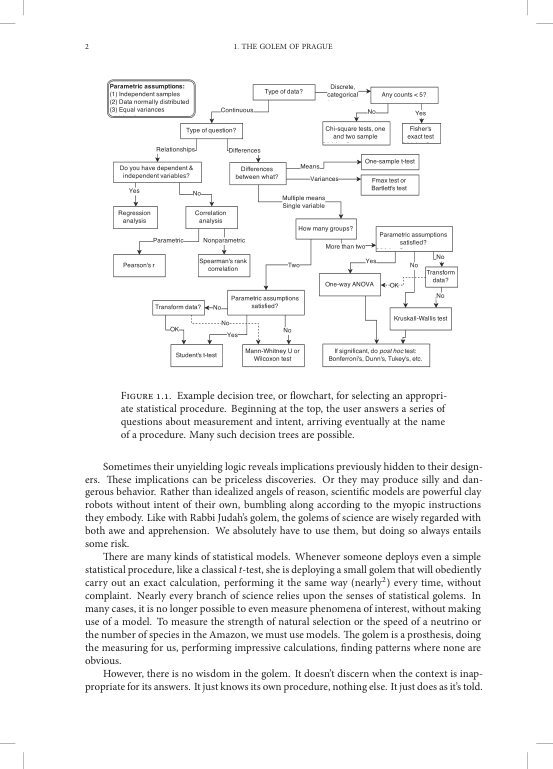

In [ ]:
path = "../RM-StatRethink-Bayes.pdf"
doc = pymupdf.open(path)
page_test = doc[15] 
page = page_test.get_pixmap().save("page.png")
Image("page.png")

In [ ]:
def get_page_text(doc, page_number: int, title_header: str) -> str:
    page_test = doc[page_number] 
    page_test_text = page_test.get_text()
    return page_test_text.split(title_header)[1].strip('\n').replace('-\n', '').replace('\n', ' ')

In [ ]:
test_text = get_page_text(doc, 15, "THE GOLEM OF PRAGUE")

In [ ]:
chapters[3:4]

NameError: name 'chapters' is not defined

In [ ]:
tts = setup_tts()
full_page_tts = tts.tts_to_file(text=test_text,
                                file_path="test.wav",
                                speaker_wav="run_tts/speaker-longer-enhanced-90p.wav",
                                language="en")
Audio(full_page_tts, rate=AUDIO_RATE)

 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.
 > Using model: xtts
TTS model loaded on cpu
 > Text splitted to sentences.
['Figure 1.1.', 'Example decision tree, or flowchart, for selecting an appropriate statistical procedure.', 'Beginning at the top, the user answers a series of questions about measurement and intent, arriving eventually at the name of a procedure.', 'Many such decision trees are possible.', 'Sometimes their unyielding logic reveals implications previously hidden to their designers.', 'These implications can be priceless discoveries.', 'Or they may produce silly and dangerous behavior.', 'Rather than idealized angels of reason, scientific models are powerful clay robots without intent of their own, bumbling along according to the myopic instructions they embody.', 'Like with Rabbi Judah’s golem, the golems of science are wisely regarded with both awe and apprehension.', 'We absolutely have to use them, but doing so always entails some risk.'

KeyboardInterrupt: 

In [ ]:
%%writefile run_tts/entrypoint.py
import modal
import os
import shutil
from audiobook import setup_tts
import pymupdf
app = modal.App("")
image = (
    modal.Image
    .debian_slim()
    .apt_install("ffmpeg")
    .pip_install(["pymupdf",
                   "TTS",
                   "torch",
                   "litellm",
                   "pydub",
                   "tqdm"])
)

PAGE_OFFSET = 13

volume = modal.Volume.from_name("model-weights-vol", create_if_missing=True)
MODEL_DIR = "/outputs/models"

@app.function(volumes={MODEL_DIR: volume}, image=image)
def do_tts(text: str, chapter_number: int, page_number: int, speaker_wav: str = "/mount/speaker-longer-enhanced-90p.wav") -> str:
    tts = setup_tts()
    file_path = f"outputs/chapter_{chapter_number}/{page_number}.wav"
    return tts.tts_to_file(text=text, speaker_wav=speaker_wav, language="en")

def get_page_text(doc, page_number: int, title_header: str) -> str:
    page_test = doc[page_number] 
    page_test_text = page_test.get_text()
    return page_test_text.split(title_header)[1].strip('\n').replace('-\n', '').replace('\n', ' ')

@app.local_entrypoint()
def launch_modal():
    path = "../RM-StatRethink-Bayes.pdf"
    chapters = load_chapters_from_yaml("chapters.yaml")
    doc = pymupdf.open(path)
    inputs_list = []
    for chapter in tqdm(chapters[0:5]):
        os.makedirs(f"outputs/chapter_{chapter['chapter_number']}", exist_ok=True)
        for page_number in range(chapter["start"] + PAGE_OFFSET, chapter["end"] + PAGE_OFFSET):
            page_text = get_page_text(doc, page_number, chapter["title"])
            inputs_list.append((page_text, chapter["chapter_number"], page_number))

    do_tts.starmap(inputs_list)
    
if __name__ == "__main__":
    launch_modal()

Overwriting run_tts/entrypoint.py


# costing

## Incomplete info

In [ ]:
example_passage = ['longer taught in science courses, unless it’s to teach how they were falsified.', 'And evidence often—but not always—has something to do with such falsification.', 'But falsification is always consensual, not logical.', 'In light of the real problems of measurement error and the continuous nature of natural phenomena, scientific communities argue towards consensus about the meaning of evidence.', 'These arguments can be messy.', 'After the fact, some textbooks misrepresent the history so it appears like logical falsification.18', 'Such historical revisionism may hurt everyone.', 'It may hurt scientists, by rendering it impossible for their own work to live up to the legends that precede them.', 'It may make science an easy target, by promoting an easily attacked model of scientific epistemology.', 'And it may hurt the public, by exaggerating the definitiveness of scientific knowledge.19 1.3.', 'Three tools for golem engineering So if attempting to mimic falsification is not a generally useful approach to statistical methods, what are we to do?', 'We are to model.', 'Models can be made into testing procedures— all statistical tests are also models20—but they can also be used to measure, forecast, and argue.', 'Doing research benefits from the ability to produce and manipulate statistical models, both because scientific problems are more general than “testing” and because the pre-made golems you maybe met in introductory statistics courses are ill-fit to many research contexts.', 'If you want to reduce your chances of wrecking Prague, then some golem engineering knowhow is needed.', 'Make no mistake: You will wreck Prague eventually.', 'But if you are a good golem engineer, at least you’ll notice the destruction.', 'And since you’ll know a lot about how your golem works, you stand a good chance to figure out what went wrong.', 'Then your next golem won’t be as bad.', 'Without the engineering training, you’re always at someone else’s mercy.', 'It can be hard to get a good education in statistical model building and criticism, though.', 'Applied statistical modeling in the early 21st century is marked by the heavy use of several engineering tools that are almost always absent from introductory, and even many advanced, statistics courses.', 'These tools aren’t really new, but they are newly popular.', 'And many of the recent advances in statistical inference depend upon computational innovations that feel more like computer science than classical statistics, so it’s not clear who is responsible for teaching them, if anyone.', 'There are many tools worth learning.', 'In this book I’ve chosen to focus on three broad ones that are in demand in both the social and biological sciences.', 'These tools are: (1) Bayesian data analysis (2) Multilevel models (3) Model comparison using information criteria These tools are deeply related to one another, so it makes sense to teach them together.', 'Understanding of these tools comes, as always, only with implementation—you can’t comprehend golem engineering until you do it.', 'And so this book focuses mostly on code, how to do things.', 'But in the rest of this section, I provide brief introductions to the three tools.', '1.3.1.', 'Bayesian data analysis.', 'For the classical Greeks and Romans, wisdom and chance were enemies.', 'Minerva (Athena), symbolized by the owl, was the personification of wisdom.', 'Fortuna (Tyche), symbolized by the wheel of fortune, was the personification of luck, both good and bad.', 'Minerva was mindful and measuring, while Fortuna was fickle and unreliable.', 'Only a fool would rely on Fortuna, while all wise folk appealed to Minerva.21']
time_to_run_one_passage_a = ((len(" ".join(example_passage))*0.76))
time_to_run_one_passage_b = ((len(" ".join(example_passage))*0.3))
price_a = time_to_run_one_passage_a * 0.000038
price_b = time_to_run_one_passage_b * 0.000164
print(f"Price for CPU: {price_a:.4f} USD, job time: {time_to_run_one_passage_a:.2f} minutes,")
print(f"Price for GPU: {price_b:.4f} USD, job time: {time_to_run_one_passage_b:.2f} minutes")

Price for CPU: 0.1027 USD, job time: 2703.32 minutes,
Price for GPU: 0.1750 USD, job time: 1067.10 minutes


1. GPU (cuda) runs:

0.24 seconds per character

0.32 seconds per character

0.36 seconds per character

0.31 seconds per character (twice)

CPU run:

0.76 seconds per character

In [ ]:
cost_per_character_gpu = 0.000164 * 0.3
cost_per_character_cpu = 0.000038 * 0.7
print(f"Cost per 1000 characters on GPU: {1000*cost_per_character_gpu:.2f} USD")
print(f"Cost per 1000 characters on CPU: {1000*cost_per_character_cpu:.2f} USD")

Cost per 1000 characters on GPU: 0.05 USD
Cost per 1000 characters on CPU: 0.03 USD


## Complete info

Above does not include cost of memory -- running in CPU costs about 20 cents in memory and 10 cents in compute every 3 minutes. 195 GiB of memory at  $0.0 24 per hr.
GPU (A10G) averages 40 cents in GPU and 0.05 cents in CPU, with basically no memory requirements.

A10G has a real-time factor of 0.34.

CPU version took 30 minutes and GPU version took about 6 minutes.

In [ ]:
# Constants
cpu_time = 30  # minutes
gpu_time = 6   # minutes
cpu_compute_cost = 0.10 / 3  # $0.10 per 3 minutes
cpu_memory_cost = 0.20 / 3   # $0.20 per 3 minutes
gpu_cost = 0.55 / 4  # $0.55 per 4 minutes

# Calculate total costs
cpu_total = (cpu_compute_cost + cpu_memory_cost) * cpu_time
gpu_total = gpu_cost * gpu_time

print(f"CPU total cost: ${cpu_total:.2f}")
print(f"GPU total cost: ${gpu_total:.2f}")
print(f"GPU is {gpu_total/cpu_total:.2f}x more expensive, {cpu_time/gpu_time:.2f}x faster")

CPU total cost: $3.00
GPU total cost: $0.83
GPU is 0.28x more expensive, 5.00x faster


In [ ]:
# !rye run modal run run_tts.entrypoint
!rye run python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 26.6 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
from bark.generation import (
    generate_text_semantic,
)
from bark.api import semantic_to_waveform
from bark import SAMPLE_RATE
from spacy import load
import numpy as np

nlp = load("en_core_web_sm")

def split_into_sentences(text):
    doc = nlp(text)
    return [sent.text for sent in doc.sents]

GEN_TEMP = 0.6
SPEAKER = "v2/en_speaker_6"
silence = np.zeros(int(0.25 * SAMPLE_RATE))  # quarter second of silence

sentences = split_into_sentences(test_text)

pieces = []
for sentence in sentences[2:4]:
    semantic_tokens = generate_text_semantic(
        sentence,
        history_prompt=SPEAKER,
        temp=GEN_TEMP,
        min_eos_p=0.05,  # this controls how likely the generation is to end
    )

    audio_array = semantic_to_waveform(semantic_tokens, history_prompt=SPEAKER,)
    pieces += [audio_array, silence.copy()]

final_audio = np.concatenate(pieces)
write_wav('test_audio.wav', SAMPLE_RATE, final_audio)
Audio('test_audio.wav', rate=SAMPLE_RATE)




































































































































































































































































































































































































































































































































100%|██████████| 513/513 [03:00<00:00,  2.83it/s]



























100%|██████████| 26/26 [01:14<00:00,  2.87s/it]

































































































































































100%|██████████| 159/159 [00:45<00:00,  3.49it/s]









100%|██████████| 8/8 [00:22<00:00,  2.85s/it]


In [ ]:
test_text, test_figure = chunk_text(pg_36.get_text(), 200, page_image="page.png", handle_figures=True)

In [ ]:
test_text

['2.1. THE GARDEN OF FORKING DATA 23 Figure 2.3',
 'Description of 2.3 : The image you shared is titled Figure 2.3 and contains a diagram of the "Garden of Forking Data" as referenced in the surrounding text. The diagram depicts a branching structure',
 'that starts at a single point and then diverges into multiple paths, reminiscent of the layout of a garden with various forking paths. At the top of the diagram, there are a series of circles',
 'representing marbles: two blue and three white in a particular sequence. Below the diagram, there is a table that lists five different conjectures about the contents of a bag, specified by the number',
 'of blue and white marbles. Next to each conjecture is the "Ways to produce" the sequence of blue and white marbles as observed, resulting in a specific number of paths that align with each conjecture.',
 'The passage describes how, after accounting for paths that are inconsistent with the observed sequence of marbles, there are only 3 out of t

In [ ]:
test_text_joined = ' '.join(test_text)
cleaned_text = describe_image("page.png", "", test_text_joined, mode="general_cleanup")

In [ ]:
test_text_joined

'2.1. THE GARDEN OF FORKING DATA 23 Figure 2.3 Description of 2.3 : The image you shared is titled Figure 2.3 and contains a diagram of the "Garden of Forking Data" as referenced in the surrounding text. The diagram depicts a branching structure that starts at a single point and then diverges into multiple paths, reminiscent of the layout of a garden with various forking paths. At the top of the diagram, there are a series of circles representing marbles: two blue and three white in a particular sequence. Below the diagram, there is a table that lists five different conjectures about the contents of a bag, specified by the number of blue and white marbles. Next to each conjecture is the "Ways to produce" the sequence of blue and white marbles as observed, resulting in a specific number of paths that align with each conjecture. The passage describes how, after accounting for paths that are inconsistent with the observed sequence of marbles, there are only 3 out of the 64 paths that rema

In [ ]:
print(cleaned_text)

2.1. THE GARDEN OF FORKING DATA

Figure 2.3. After eliminating paths inconsistent with the observed sequence, only 3 of the 64 paths remain.

The image you shared is titled Figure 2.3 and contains a diagram of the "Garden of Forking Data" as referenced in the surrounding text. The diagram depicts a branching structure that starts at a single point and then diverges into multiple paths, reminiscent of the layout of a garden with various forking paths. At the top of the diagram, there are a series of circles representing marbles: two blue and three white in a particular sequence. Below the diagram, there is a table that lists five different conjectures about the contents of a bag, specified by the number of blue and white marbles. Next to each conjecture is the "Ways to produce" the sequence of blue and white marbles as observed, resulting in a specific number of paths that align with each conjecture.

The passage continues: 

Now we count up all the ways each conjecture could produce th

In [ ]:
# len(doc)
doc = fitz.open('mount/book.pdf')


NameError: name 'fitz' is not defined

In [ ]:
def make_transcriptions(path, tts, page_start=0, page_end=1):
    doc = fitz.open(path)
    for index, page in enumerate(doc[page_start:page_end]):
        audio_path = "outputs/pages/{0}".format(index)
        page_path = "outputs/pages/{0}/page.png".format(index)
        if not os.path.exists(audio_path):
            os.makedirs(audio_path)
        page_image = page.get_pixmap().save(page_path)
        initial_text, _figure = chunk_text(page.get_text(), 200, page_image=page_path, handle_figures=True)
        initial_text_joined = ' '.join(initial_text)
        cleaned_text = describe_image(page_path, "", initial_text_joined, mode="general_cleanup")
        final_text_to_write, _figure = chunk_text(cleaned_text, 200, page_image=page_path, handle_figures=False)
        for index, text_chunk in tqdm(enumerate(final_text_to_write)):
            tts.tts_to_file(text=text_chunk,
                            file_path=audio_path + "/{0}.wav".format(index),
                            speaker_wav="speaker-longer-enhanced-90p.wav",
                            language="en")
        concatenate_audio_pydub(audio_path, "combined.wav")

In [ ]:
# this equals about 24 hours in CPU time, which isn't terrible I guess.
#Should look into huggingface native for actual GPU support.

In [ ]:
# Example usage
concatenate_audio_pydub("outputs/pages/36/", "combined_audio.wav")

Reading audio files: 100%|██████████| 18/18 [00:00<00:00, 1988.35it/s]


In [ ]:
# code golf idea
class UnwrappingList:
    def __init__(self, items):
        self.items = items
    
    def __iter__(self):
        return iter(self.items)
    
    def __getitem__(self, index):
        if isinstance(index, slice):
            return self
        return list(self.items)[index]

def unpack_generator(items):
    return UnwrappingList(items)

def test(text):
    text = [text]
    return text

result = test(unpack_generator(x for x in ["a", "b"]))
for i in result:
    print(i)